<a href="https://colab.research.google.com/github/jerrymart/Machine-Learning-Projects/blob/main/Linear_Regression_Factors_Affecting_Revenue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business Case

Investigate "what factors/variables affect the performance of revenue"

Our aim is to go back to the business and make suggestions about how to generate more revenue

Make Revenue predictions given specific variable values


In [1]:
# Packages / libraries
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score,accuracy_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_val_score

#Regressors
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor


%matplotlib inline


# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(12,10)})

## Loading the Raw Data

In [2]:
raw_data = pd.read_csv('/content/Marketing_RawData.csv')

In [3]:
raw_data.head()

,Date,Week,Week_ID,Month,Month_ID,Year,Day_Name,Visitors,Revenue,Marketing Spend,Promo
0,09/11/2020,46.0,34.0,11.0,11.0,2020.0,Monday,707.0,465.0,651.375,No Promo
1,10/11/2020,46.0,34.0,11.0,11.0,2020.0,Tuesday,1455.0,10386.0,1298.250,Promotion Red
2,11/11/2020,46.0,34.0,11.0,11.0,2020.0,Wednesday,1520.0,12475.0,1559.375,Promotion Blue
3,12/11/2020,46.0,34.0,11.0,11.0,2020.0,Thursday,1726.0,11712.0,1801.750,No Promo
4,13/11/2020,46.0,34.0,11.0,11.0,2020.0,Friday,2134.0,10000.0,2614.500,No Promo


In [4]:
# print the shape
print(raw_data.shape)

(185, 11)


## Data Preprocessing

### Exploratory Data Analysis

In [5]:
# Checking for null values

raw_data.isnull().sum()

Date               0
Week               3
Week_ID            3
Month              3
Month_ID           3
Year               3
Day_Name           3
Visitors           3
Revenue            3
Marketing Spend    3
Promo              3
dtype: int64

In [6]:
# Visualize the NULL observations
raw_data[raw_data['Week'].isnull()]

,Date,Week,Week_ID,Month,Month_ID,Year,Day_Name,Visitors,Revenue,Marketing Spend,Promo
182,10/05/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,11/05/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,12/05/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Deleting the NULL values
raw_data = raw_data.dropna(subset = ['Week'])  #raw_data.dropna() will drop all na in the data

# Printing the shape
raw_data.shape

# Visualize the NULL observations
raw_data.isnull().sum()

Date               0
Week               0
Week_ID            0
Month              0
Month_ID           0
Year               0
Day_Name           0
Visitors           0
Revenue            0
Marketing Spend    0
Promo              0
dtype: int64

In [9]:
# Investigate all the elements whithin each Feature 

for column in raw_data:
    unique_vals = np.unique(raw_data[column])
    nr_values = len(unique_vals)
    if nr_values < 10:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature Date :182
The number of values for feature Week :28
The number of values for feature Week_ID :28
The number of values for feature Month :7 -- [1.000000 2.000000 3.000000 4.000000 5.000000 11.000000 12.000000]
The number of values for feature Month_ID :7 -- [11.000000 12.000000 13.000000 14.000000 15.000000 16.000000 17.000000]
The number of values for feature Year :2 -- [2020.000000 2021.000000]
The number of values for feature Day_Name :7 -- ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
The number of values for feature Visitors :175
The number of values for feature Revenue :181
The number of values for feature Marketing Spend :182
The number of values for feature Promo :3 -- ['No Promo' 'Promotion Blue' 'Promotion Red']


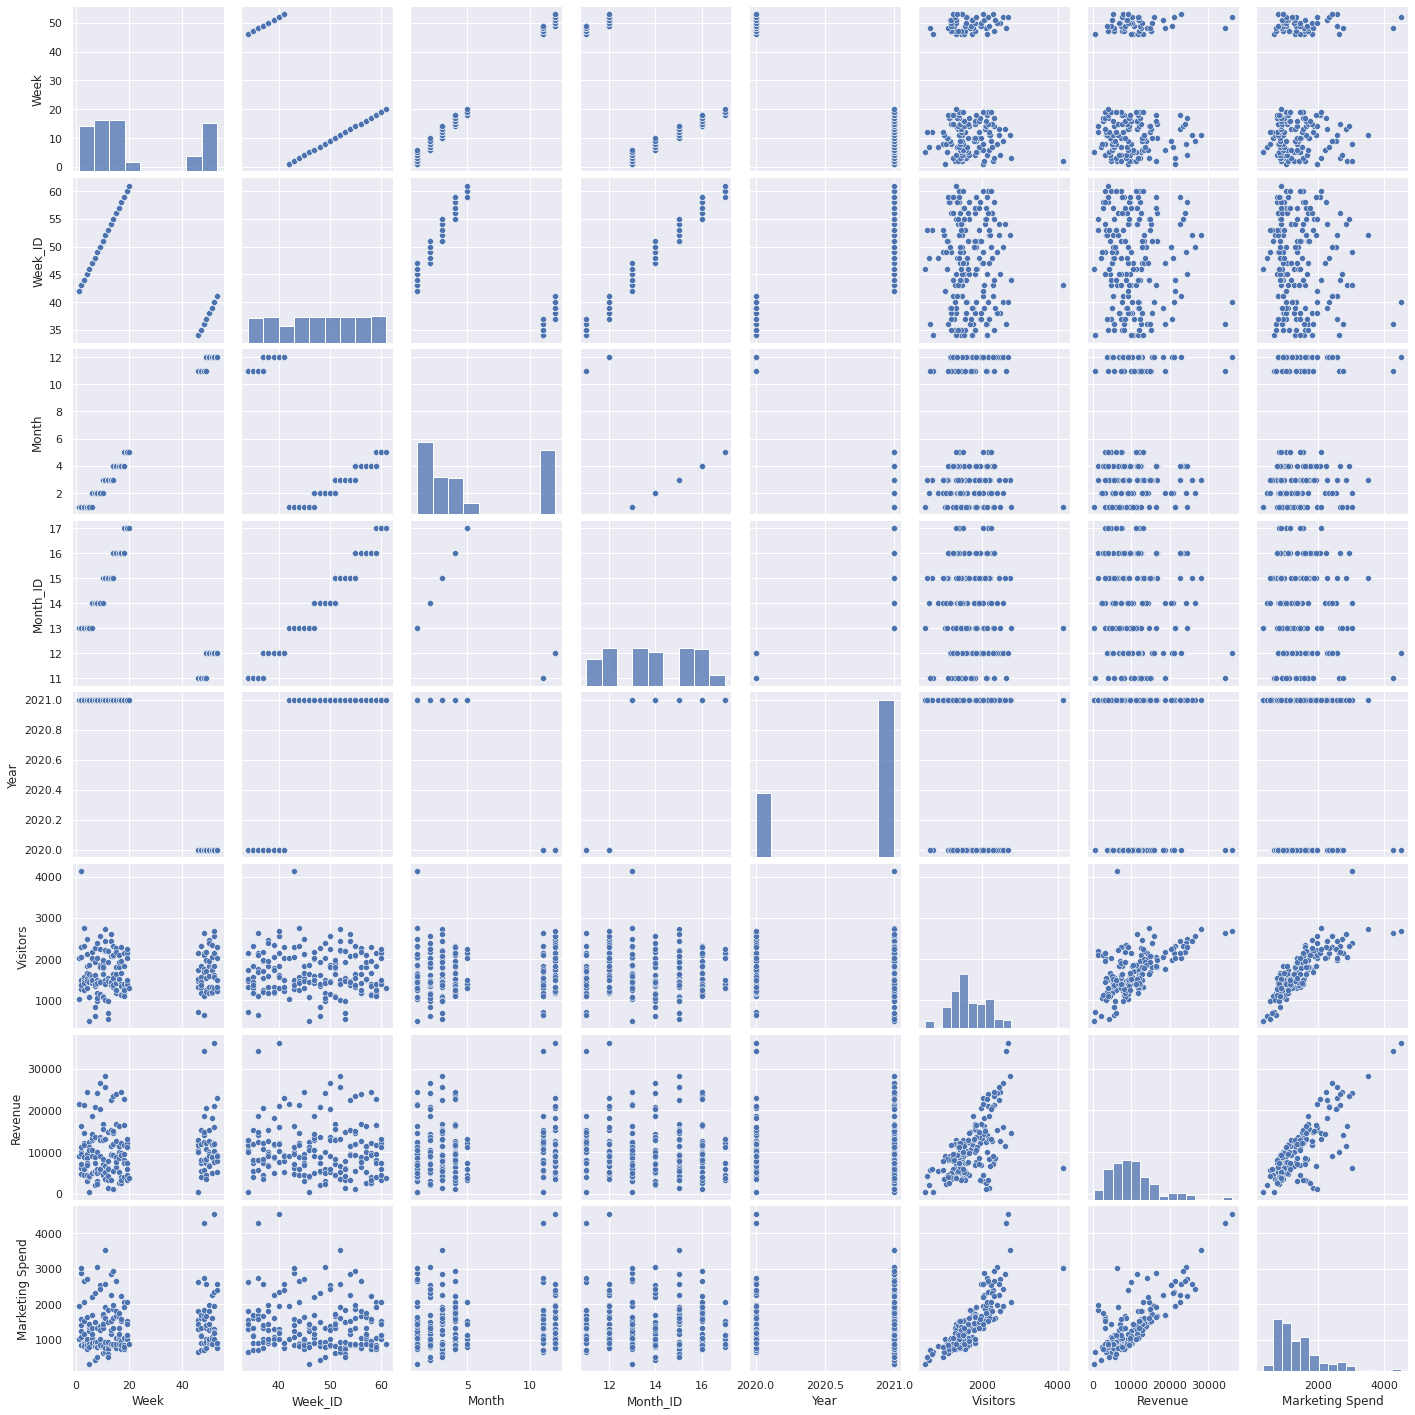

In [13]:
# Visualize the data using seaborn Pairplots

g = sns.pairplot(raw_data)

# Notes: Do not run this on a big dataset. Filter the columns first

In [9]:
raw_data.columns

Index(['Date', 'Week', 'Week_ID', 'Month', 'Month_ID', 'Year', 'Day_Name',
       'Visitors', 'Revenue', 'Marketing Spend', 'Promo'],
      dtype='object')

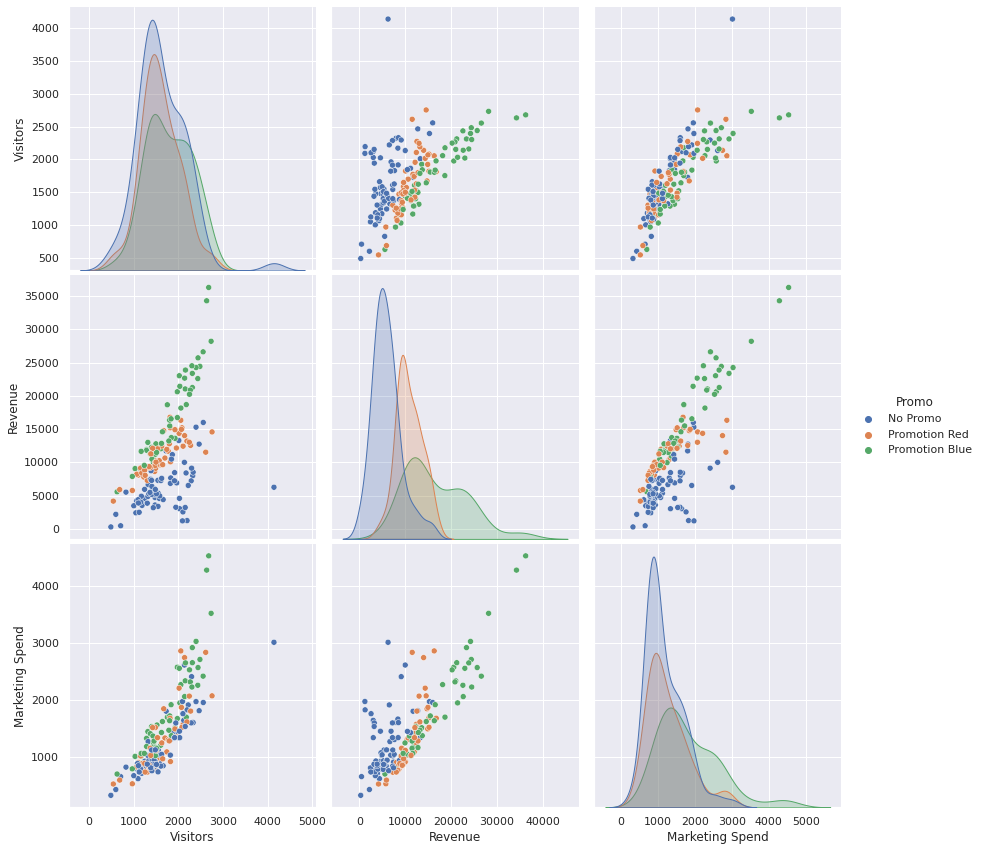

In [14]:
# Visualising a Subset of our data - important features as shown in by plot above
#there are good correlations on feature [Visitors', 'Revenue', 'Marketing Spend]

g = sns.pairplot(raw_data[['Visitors', 'Revenue', 'Marketing Spend', 'Promo']], hue = 'Promo', height = 4)

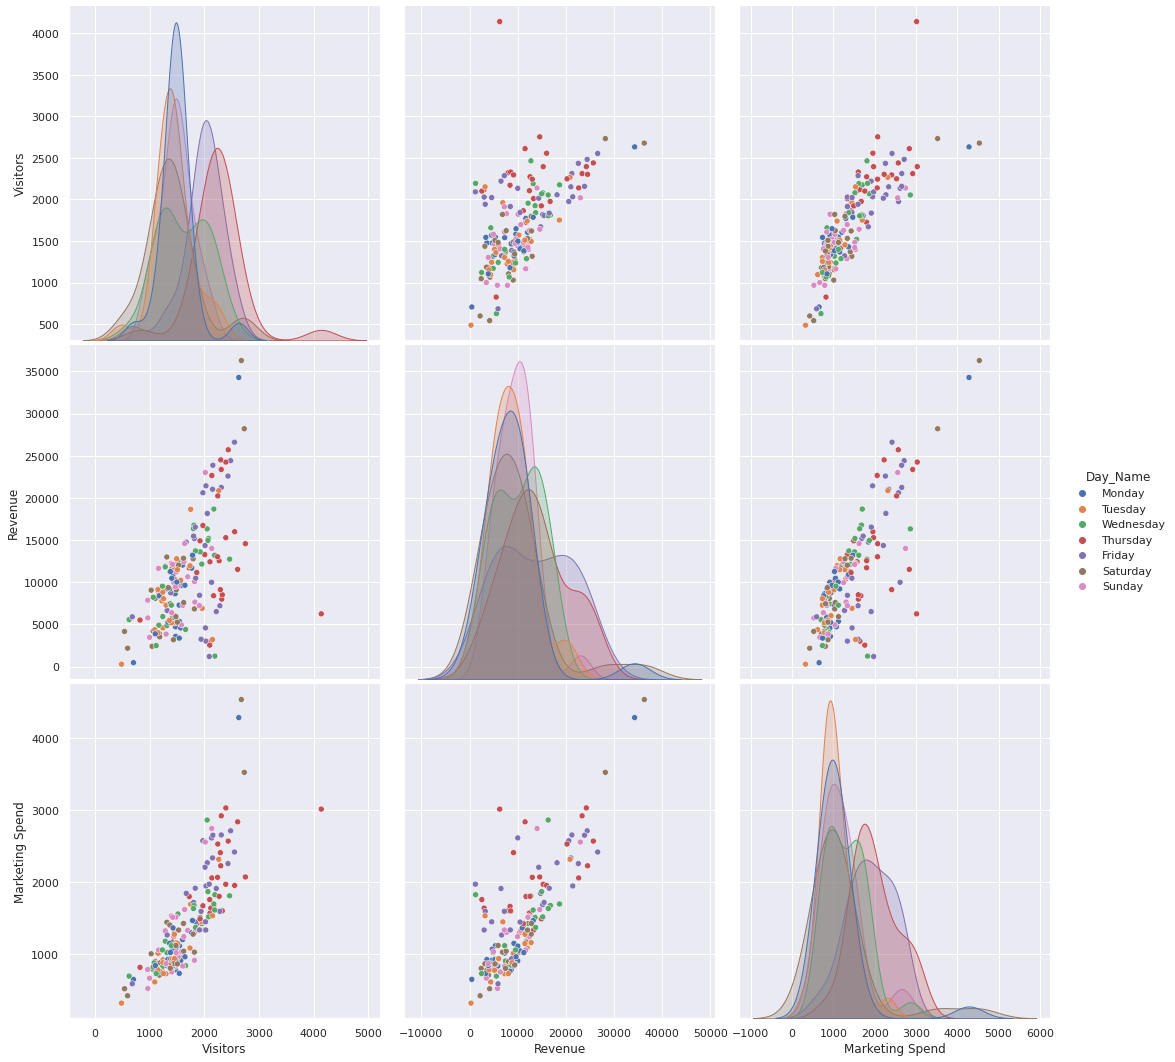

In [15]:
# Visualising revenue made daily wrt marketing spend, visitors

g = sns.pairplot(raw_data[['Visitors', 'Revenue', 'Marketing Spend', 'Day_Name']], hue = 'Day_Name', height = 5)

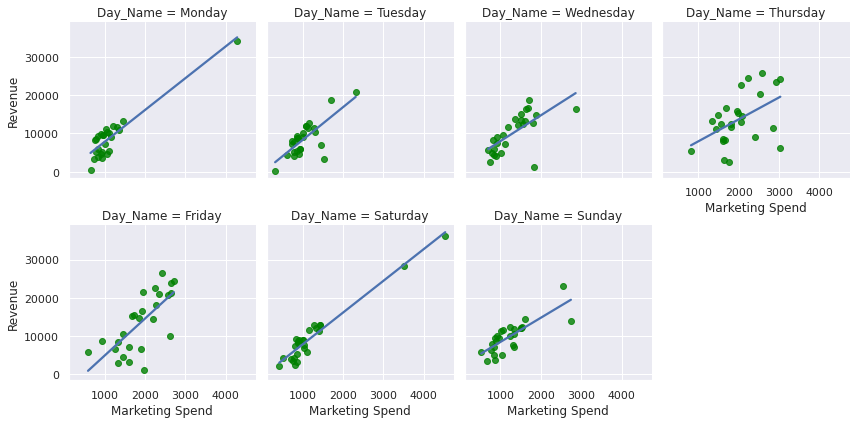

In [16]:
# Let us check the revenue made daily wrt marketing spend

g = sns.lmplot(x = 'Marketing Spend', y = 'Revenue', data = raw_data, col = 'Day_Name', col_wrap = 4, height = 3, 
              scatter_kws = {'color':'green'}, ci = False)

This shw that each day has impact on revenue

Hence we wil keep this in our data for use

## Detecting Outlier
We will remove outliers in Revenue with our BOXPLOT

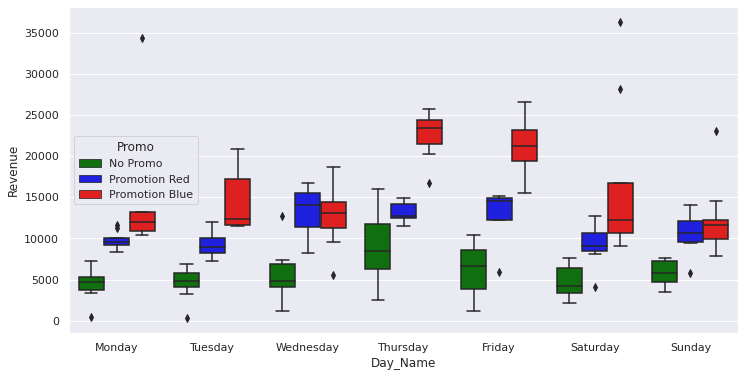

In [17]:
# Investigate the distribution of Revenue by Categorical Variables
#We wil use the boxplot to remove outliers
pal = ['green', 'blue','red']

plt.figure(figsize=(12,6))
g = sns.boxplot(x = 'Day_Name', y = 'Revenue', data = raw_data, hue = 'Promo', palette = pal)
               
#ax = sns.swarmplot(x = 'Day_Name', y = 'Revenue', data = raw_data, palette = pal, hue = 'Promo')

It is clear that majority of our revenue are below 27000

N:B- Some outliers like these are vry useful in building the model, so you want to be careful not to delete those outliers

This is just to show how we can delete our outliers

## Data Cleaning

In [18]:
# Deleting outliers

raw_data = raw_data[raw_data['Revenue'] < 27000]

raw_data.shape

(179, 11)

In [19]:
# Selecting usefull columns only
raw_data = raw_data[['Day_Name','Visitors', 'Revenue', 'Marketing Spend', 'Promo']]

#visualize the raw data
raw_data.head()

,Day_Name,Visitors,Revenue,Marketing Spend,Promo
0,Monday,707.0,465.0,651.375,No Promo
1,Tuesday,1455.0,10386.0,1298.250,Promotion Red
2,Wednesday,1520.0,12475.0,1559.375,Promotion Blue
3,Thursday,1726.0,11712.0,1801.750,No Promo
4,Friday,2134.0,10000.0,2614.500,No Promo


In [20]:
# Making categorical variables into numeric representation
# We can also do this with Label Encoding and OneHotEncoder from the preprocessing library

raw_data_dummy = pd.get_dummies(raw_data[['Promo', 'Day_Name']], drop_first=True)

raw_data_dummy.head(2)

,Promo_Promotion Blue,Promo_Promotion Red,Day_Name_Monday,Day_Name_Saturday,Day_Name_Sunday,Day_Name_Thursday,Day_Name_Tuesday,Day_Name_Wednesday
0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,1,0


In [22]:
raw_data_dummy.shape

(179, 8)

In [23]:
#Concat with raw data
new_raw_data = pd.concat([raw_data, raw_data_dummy], axis=1)

#check the shape
new_raw_data.shape

(179, 13)

In [24]:
#Drop the columns=['Promo', 'Day_Name']

new_raw_data.drop(columns=['Promo', 'Day_Name'],axis=1,inplace=True)

In [25]:
#Check the head and shape
print(new_raw_data.shape)

new_raw_data.head(3)

(179, 11)


,Visitors,Revenue,Marketing Spend,Promo_Promotion Blue,Promo_Promotion Red,Day_Name_Monday,Day_Name_Saturday,Day_Name_Sunday,Day_Name_Thursday,Day_Name_Tuesday,Day_Name_Wednesday
0,707.0,465.0,651.375,0,0,1,0,0,0,0,0
1,1455.0,10386.0,1298.250,0,1,0,0,0,0,1,0
2,1520.0,12475.0,1559.375,1,0,0,0,0,0,0,1


In [25]:
new_raw_data.columns

Index(['Visitors', 'Revenue', 'Marketing Spend', 'Promo_Promotion Blue',
       'Promo_Promotion Red', 'Day_Name_Monday', 'Day_Name_Saturday',
       'Day_Name_Sunday', 'Day_Name_Thursday', 'Day_Name_Tuesday',
       'Day_Name_Wednesday'],
      dtype='object')

## Standardize The Data

**NOTE: Do not standardize the target column whenever standardization is done in ML preprocessing**

In [26]:
from sklearn.preprocessing import MinMaxScaler
# Scaling our columns except the target
scale_vars = ['Visitors', 'Marketing Spend']

scaler = MinMaxScaler()
new_raw_data[scale_vars] = scaler.fit_transform(new_raw_data[scale_vars]) #new_raw_data[scale_vars] -> making the np.aaary new_raw_data a dataframe

new_raw_data.head(2)

,Visitors,Revenue,Marketing Spend,Promo_Promotion Blue,Promo_Promotion Red,Day_Name_Monday,Day_Name_Saturday,Day_Name_Sunday,Day_Name_Thursday,Day_Name_Tuesday,Day_Name_Wednesday
0,0.059984,465.0,0.121591,0,0,1,0,0,0,0,0
1,0.264859,10386.0,0.360389,0,1,0,0,0,0,1,0


# Feature Selection

We will investigate te important feauture and use those in our data

In this example, we do not have many variables so we should use all of the data but in some cases, you have thousands of variables and you will need to filter them in order to save computational time



2 ways to help us select the important features are:

-Feature Importance Using Tree Base estimators

-Correlation Method

-Correlation methodshould only beused when there are not many features in a dataset

## Steps of Running Feature Importance

-Split the data into X & y

-Run a Tree-based estimators (i.e. decision trees & random forests)

-Run Feature Importance

In [90]:
# Split the data into X & y

X = new_raw_data.drop('Revenue', axis = 1).values 

X_t = new_raw_data.drop('Revenue', axis = 1)
y = new_raw_data['Revenue']

print(X.shape)
print(y.shape)

(179, 10)
(179,)


In [91]:
print(type(y))

type(X)

<class 'pandas.core.series.Series'>


numpy.ndarray

In [92]:
# Run a Tree-based estimators (i.e. decision trees & random forests)
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=15, criterion  = 'entropy', max_depth = 10)
dt.fit(X,y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

**For a Large data with many colums, a recommended optimal approach t do this is using RandomizedSearchCV to get the best estimators for the decisionTree**

Notes:

The importance of a feature is calculated as the (normalized) total reduction of entropy (other criterions too) brought by that feature or the higher information gain

To understand the maths, read this: https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3

In [102]:
# Calculating FI
for i, column in enumerate(new_raw_data.drop('Revenue', axis=1)):
    print('Importance of feature {}:, {:.3f}'.format(column, dt.feature_importances_[i]))
    
    #make a dataframe of the fi
    f_importance = pd.DataFrame({'Variable': [column], 'Feature Importance Score': [dt.feature_importances_[i]]})
    
    try:
        final_fimportance = pd.concat([final_fimportance,f_importance], ignore_index = True)
    except:
        final_fimportance = f_importance

Importance of feature Visitors:, 0.340
Importance of feature Marketing Spend:, 0.480
Importance of feature Promo_Promotion Blue:, 0.037
Importance of feature Promo_Promotion Red:, 0.049
Importance of feature Day_Name_Monday:, 0.017
Importance of feature Day_Name_Saturday:, 0.017
Importance of feature Day_Name_Sunday:, 0.021
Importance of feature Day_Name_Thursday:, 0.020
Importance of feature Day_Name_Tuesday:, 0.012
Importance of feature Day_Name_Wednesday:, 0.008


In [103]:
# Ordering the data
final_fimportance = final_fimportance.sort_values('Feature Importance Score', ascending = False).reset_index() 

final_fimportance

,index,Variable,Feature Importance Score
0,1,Marketing Spend,0.479734
1,0,Visitors,0.340289
2,3,Promo_Promotion Red,0.048814
3,2,Promo_Promotion Blue,0.036747
4,6,Day_Name_Sunday,0.020764
5,7,Day_Name_Thursday,0.019908
6,5,Day_Name_Saturday,0.016918
7,4,Day_Name_Monday,0.016918
8,8,Day_Name_Tuesday,0.012234
9,9,Day_Name_Wednesday,0.007674


## **Correlation Approach**

**Correlation can only work for the non-categorical features, we will not use this ina scalable business case
Rather we use tree-based estimator approach as shown in Feature importance method below**

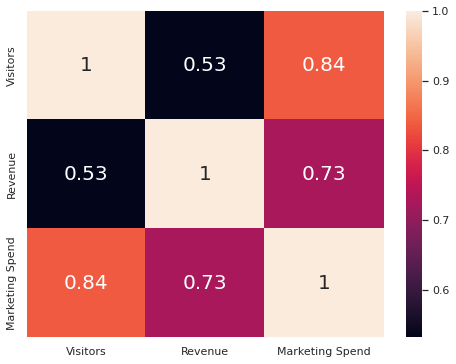

In [43]:
# Running Correlation
plt.figure(figsize=(8,6))

hm = new_raw_data[['Visitors','Revenue','Marketing Spend']].corr()

# Visualizing Correlation with a Heatmap
sns.heatmap(hm, annot = True, annot_kws={'size':20},)

## Splitting the Raw Data - Hold-out validation

In [104]:
# Hold-out validation

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size = 0.2, random_state=15)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

# Official Doc: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

(143, 10)
(143,)
(36, 10)
(36,)


In [81]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [53]:
type(y_train)

pandas.core.series.Series

## Building Linear Regression Model 

In [105]:
# Training the Regression

lm = LinearRegression(fit_intercept = True)     #fit_intercept = True => so we can make some predictions later on
lm.fit(X_train, y_train)


#Prediction
y_pred = lm.predict(X_train)

## Evaluating the Model

In [106]:
# Model Accuracy on training dataset

print('The lm.score Accuracy  on the training dataset is: ', lm.score(X_train, y_train) )
print('The r2_score Accuracy  on the training dataset is: ',r2_score(y_train,y_pred) )   

print("")
#Model Accuracy on testing dataset
print('The Accuracy  on the testing dataset is: ', lm.score(X_test, y_test) )

print("")
# The Root Mean Squared Error (RMSE)
print('The RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train,y_pred)))
print('The RMSE  on the testing dataset is: ',sqrt(mean_squared_error(y_test,lm.predict(X_test))))

print("")
# The Mean Absolute Error (MAE)
print('The MAE  on the training dataset is: ',mean_absolute_error(y_train,y_pred))
print('The MAE  on the testing dataset is: ',mean_absolute_error(y_test,lm.predict(X_test)))


# R2 Link: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
# RMSE Link: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
# MAE Link: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

The lm.score Accuracy  on the training dataset is:  0.791949990505602
The r2_score Accuracy  on the training dataset is:  0.791949990505602

The Accuracy  on the testing dataset is:  0.751190386538668

The RMSE  on the training dataset is:  2618.561282656437
The RMSE  on the testing dataset is:  2340.4200873490117

The MAE  on the training dataset is:  1928.0670665528876
The MAE  on the testing dataset is:  1692.3835577162292


In [107]:
# Coefficients
print('Coefficients: ', lm.coef_ )

print("")
# The Intercept
print('Intercept: ', lm.intercept_)

print("")
print("Number of features", len(lm.coef_))

Coefficients:  [3549.389005 10010.958448 8020.567130 4867.062489 -1090.314633
 -1640.247332 -893.873305 76.815742 -587.920825 -1030.499814]

Intercept:  2167.1859892986213

Number of features 10


In [108]:
#y = mx +c
y_target = sum(lm.coef_ + lm.intercept_)
y_target

42953.79679796023

Text(0.5, 1.0, 'Actuals Vs Predicted Values')

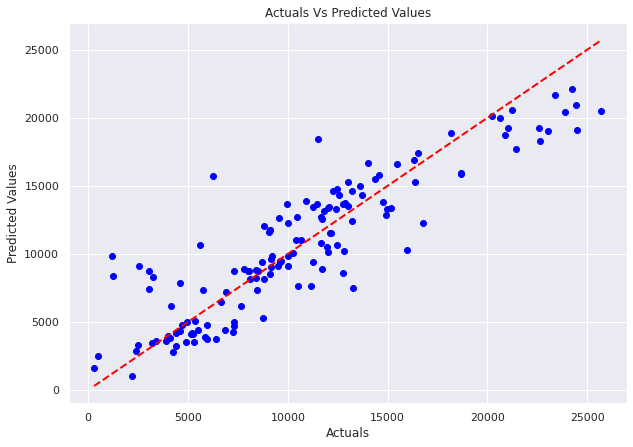

In [109]:
# Plotting Actuals Vs Predicted

plt.figure(figsize=(10,7))

plt.scatter(y_train, y_pred, c='blue')
#fit a linear line on it
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', c='red', lw=2)

plt.xlabel('Actuals')
plt.ylabel('Predicted Values')
plt.title('Actuals Vs Predicted Values')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Actuals Vs Residuals')

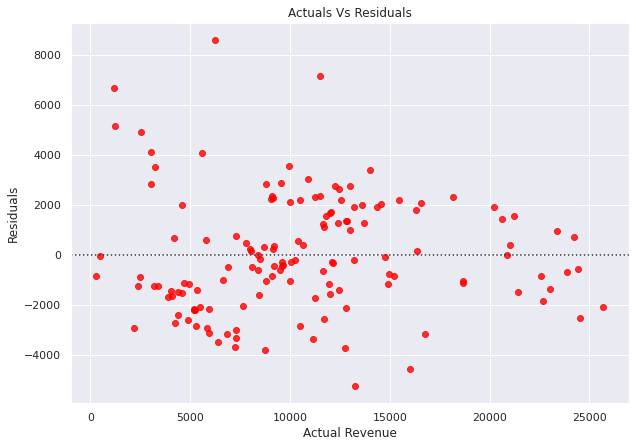

In [110]:
# Ploting Residuals

plt.figure(figsize=(10,7))

sns.residplot(y_train, y_pred, color='red')

plt.xlabel('Actual Revenue')
plt.ylabel('Residuals')
plt.title('Actuals Vs Residuals')

The next step should be to go back, remove more outliers and check if our model can be improved

In [112]:
X_t.columns

Index(['Visitors', 'Marketing Spend', 'Promo_Promotion Blue',
       'Promo_Promotion Red', 'Day_Name_Monday', 'Day_Name_Saturday',
       'Day_Name_Sunday', 'Day_Name_Thursday', 'Day_Name_Tuesday',
       'Day_Name_Wednesday'],
      dtype='object')

#  Usese our L. Regression model to Make Predictions

In [136]:
# Passing Coeff into a table

Coeff = lm.coef_
Coeff.shape

(10,)

In [137]:
# Reshaping
Coeff = Coeff.reshape(-1,10) # 10 must correspond with our coulmn lenght

# Creating a Dataframe
Coeff_df = pd.DataFrame(Coeff, columns = [X_t.columns])

# Displaying 
Coeff_df

,Visitors,Marketing Spend,Promo_Promotion Blue,Promo_Promotion Red,Day_Name_Monday,Day_Name_Saturday,Day_Name_Sunday,Day_Name_Thursday,Day_Name_Tuesday,Day_Name_Wednesday
0,3549.389005,10010.958448,8020.56713,4867.062489,-1090.314633,-1640.247332,-893.873305,76.815742,-587.920825,-1030.499814


In [138]:
Coeff_df.columns

MultiIndex([(            'Visitors',),
            (     'Marketing Spend',),
            ('Promo_Promotion Blue',),
            ( 'Promo_Promotion Red',),
            (     'Day_Name_Monday',),
            (   'Day_Name_Saturday',),
            (     'Day_Name_Sunday',),
            (   'Day_Name_Thursday',),
            (    'Day_Name_Tuesday',),
            (  'Day_Name_Wednesday',)],
           )

In [147]:
# Making Predictions                        

# Variables

Day = 'Day_Name_Monday'
Visitors = 8000
Marketing_Spend = 5000
Promo = 'Promo_Promotion Red'

# Regression Formula for pred
# y = a + bx + ..   # Where y = price, a = intercept,  b = no. of Visitors and x = coefficient of engine size

# Prediction Calculator
pred1 = (lm.intercept_) + (Coeff_df[Day].values[0] * 1) + (Coeff_df['Visitors'].values[0] * Visitors) + (Coeff_df['Marketing Spend'].values[0] * Marketing_Spend) + (Coeff_df[Promo].values[0] * 1)

print('The predicted Revenue is: ', pred1)

####Where we can apply this as a business and how? ##############


 1. We can create a prediction tool for upcoming marketing campaigns 

 2. We can analyse past marketing campaigns and suggest what work, what did not work, 
 how much money we could have made and suggest changes - campaign optimisation

3. We can predict the potential of Stores or Accounts or Channels or Campaigns and compare that with what they actually achieving.

Then we can grade them and make suggestions (over achieving vs underachieving Vs potential Accounts)

4. We can deploy the model in a server/cloud and automatically adjusting the campaigns that generate the most money depending on the day.

At the same time, keep running A/B testing with new campaigns (ideas) and re-adjust if needed